In [1]:
# Data: time-serie data from smartwatch or smartwatch data
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# The smartwatch historical/time-seris data to visualize
data_path_1xn = 'data/smartwatch_data/experimental_data_analysis/Basis_Watch_Data.csv'
watch_txn = pd.read_csv(data_path_1xn)

# txn: time-space from the space-time theory
watch_txn.head()

# Exploring the data rows-t and cols-n
watch_txn[:20]

,date,calories,gsr,heart-rate,skin-temp,steps
0,2014-08-08 15:18Z,0.4,NaN,NaN,NaN,0.0
1,2014-08-08 15:19Z,1.4,NaN,NaN,NaN,0.0
2,2014-08-08 15:20Z,1.4,NaN,NaN,NaN,0.0
3,2014-08-08 15:21Z,1.3,NaN,NaN,NaN,0.0
4,2014-08-08 15:22Z,1.4,NaN,NaN,NaN,0.0
5,2014-08-08 15:23Z,1.4,NaN,NaN,NaN,0.0
6,2014-08-08 15:24Z,1.4,NaN,NaN,NaN,0.0
7,2014-08-08 15:25Z,1.4,NaN,NaN,NaN,0.0
8,2014-08-08 15:26Z,1.4,NaN,NaN,NaN,0.0
9,2014-08-08 15:27Z,1.4,NaN,NaN,NaN,0.0


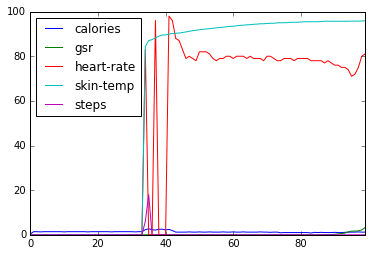

In [2]:
# Data: cleaning
# Getting rid of NaN
watch_txn = watch_txn.fillna(value=0.0)
watch_txn[:100]

# # Plotting the smartwatch data
watch_txn[:100].plot() #x='dteday', y='cnt'

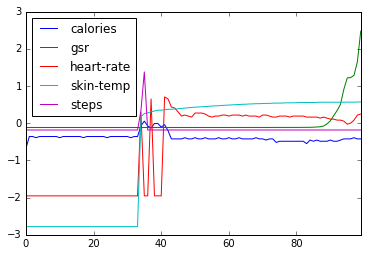

In [3]:
# Data: Preprocessing 
# Batch normalization
features_1x5 = ['calories', 'gsr', 'heart-rate', 'skin-temp', 'steps']

# Store scalings in a dictionary so we can convert back later
scaled_features_5x2 = {}
for each_name in features_1x5:
    mean_1x1_val, std_1x1_val = watch_txn[each_name].mean(), watch_txn[each_name].std() # std: standard dev. = square-root of MSE/Variance
    scaled_features_5x2[each_name] = [mean_1x1_val, std_1x1_val]
    watch_txn.loc[:, each_name] = (watch_txn[each_name] - mean_1x1_val)/std_1x1_val

# Drop date from the dataset
watch_txn = watch_txn.drop(labels='date', axis=1)

# Visualize the data again to double-check visually again
watch_txn[:100].plot()

In [4]:
# # Data: text data
# import numpy as np
# # if __name__ == '__main__':
# with open('data/text_data/japan.txt', 'r') as f:
#     txt = f.read()

# X = []
# y = []

# # char_to_idx = {char: i for i, char in enumerate(set(txt))}
# # idx_to_char = {i: char for i, char in enumerate(set(txt))}

# X = [X for x in watch_txn]
# X = np.array(X)
# y = [y for x in watch_txn[1:]]
# y.append(0)

X = np.array(watch_txn)
y = np.array(watch_txn[1:])
X.shape, y.shape
# y = [watch_txn[1:]]
# y.append(np.zeros_like(y[0].shape))
# y=np.array(y)
# y.shape
y_last_row = np.zeros_like(y[0])
row = np.array([y_last_row])
y = np.row_stack((y, row))
y.shape, X.shape, y_last_row.shape, row.shape, row

((1011347, 5), (1011347, 5), (5,), (1, 5), array([[ 0.,  0.,  0.,  0.,  0.]]))

In [34]:
# Model
import impl.loss as loss_fun
import impl.layer as l
import impl.utils as util
import impl.NN as nn

class RNN(nn.NN):

    def __init__(self, D, H, L):
        self.D = D
        self.H = H
        self.L = L
        self.losses = {'train':[], 'valid':[], 'test':[]}
        super().__init__(D, D, H, None, None, loss='cross_ent', nonlin='relu')

    def _init_model(self, D, C, H):
        m = dict(
            Wxh=np.random.randn(D, H) / np.sqrt(D / 2.),
            Whh=np.random.randn(H, H) / np.sqrt(H / 2.),
            Why=np.random.randn(H, D) / np.sqrt(C / 2.),
            bh=np.zeros((1, H)),
            by=np.zeros((1, D))
            )
        self.model = []
        for l in range(self.L):
            self.model.append(m)
            
    def initial_state(self):
        return np.zeros((1, self.H))

    def forward(self, X, h, m):
        Wxh, Whh, Why = m['Wxh'], m['Whh'], m['Why']
        bh, by = m['bh'], m['by']

        hprev = h.copy()

        h, h_cache = l.tanh_forward(X @ Wxh + hprev @ Whh + bh)
        y, y_cache = l.fc_forward(h, Why, by)

        cache = X, Whh, h, hprev, y, h_cache, y_cache, Wxh

        return y, h, cache

    def backward(self, dy, dh, cache):
        X, Whh, h, hprev, y, h_cache, y_cache, Wxh = cache

        dh_next = dh.copy()
        
        # Hidden to output gradient
        dh, dWhy, dby = l.fc_backward(dy, y_cache)
        dh += dh_next
        dby = dby.reshape((1, -1))

        # tanh
        dh = l.tanh_backward(dh, h_cache)

        # Hidden gradient
        dbh = dh
        dWhh = hprev.T @ dh
        dWxh = X.T @ dh
        
        dX = dh @ Wxh.T
        dh = dh @ Whh.T

        grad = dict(Wxh=dWxh, Whh=dWhh, Why=dWhy, bh=dbh, by=dby)
        
        return dX, dh, grad

    def train_forward(self, X_train, h):
        ys, caches = [], []
        h_init = h.copy()
        h = []
        for l in range(self.L):
            h.append(h_init.copy())
            caches.append([])
            
        for X in X_train:
            y = X.reshape(1, -1)
            for l in range(self.L):
                y, h[l], cache = self.forward(y, h[l], self.model[l])
                caches[l].append(cache)
                
            ys.append(y)
            
        return ys, caches

    def l2_regression_NEW(self, y_pred, y_train):
        m = y_pred.shape[0]

        data_loss = 0.5 * np.sum((y_train - y_pred)**2) / m
    
        return data_loss

    def dl2_regression_NEW(self, y_pred, y_train):
        m = y_pred.shape[0]

        dy = 0.5 * ((y_train - y_pred)**2) / m
#         dy = dy.reshape(-1, 1)
#         dy = dy.reshape(1, -1)

        return dy

    def loss_function(self, y_train, ys):
        loss, dys = 0.0, []

        for y_pred, y in zip(ys, y_train):
            loss += self.l2_regression_NEW(y_pred, y)/ y_train.shape[0]
            dy = self.dl2_regression_NEW(y_pred, y)
            dys.append(dy)
            
        return loss, dys

    def train_backward(self, dys, caches):
        dh, grad, grads = [], [], []
        for l in range(self.L):
            dh.append(np.zeros((1, self.H)))
            grad.append({key: np.zeros_like(val) for key, val in self.model[0].items()})
            grads.append({key: np.zeros_like(val) for key, val in self.model[0].items()})
            
        for t in reversed(range(len(dys))):
            dX = dys[t]
            for l in reversed(range(self.L)):
                dX, dh[l], grad[l] = self.backward(dX, dh[l], caches[l][t])
                for k in grad[0].keys():
                    grads[l][k] += grad[l][k]
                
        return dX, grads

In [35]:
import impl.constant as c
import copy
from sklearn.utils import shuffle as skshuffle

def get_minibatch(X, y, minibatch_size, shuffle=True):
    minibatches = []

    if shuffle:
        X, y = skshuffle(X, y)

    for i in range(0, X.shape[0], minibatch_size):
        X_mini = X[i:i + minibatch_size]
        y_mini = y[i:i + minibatch_size]

        minibatches.append((X_mini, y_mini))

    return minibatches

def adam_rnn(nn, X_train, y_train, alpha, mb_size, n_iter, print_after):
    minibatches = get_minibatch(X_train, y_train, mb_size, shuffle=False)

    idx = 0
    state = nn.initial_state()
#     loss = np.log(len(set(X_train)))
#     smooth_loss = -np.log(1.0 / len(set(X_train)))

    
    M, R = [], []
    for l in range(nn.L):
        M.append({k: np.zeros_like(v) for k, v in nn.model[0].items()})
        R.append({k: np.zeros_like(v) for k, v in nn.model[0].items()})
        
    beta1 = .9
    beta2 = .999

    for iter in range(1, n_iter + 1):

        if idx >= len(minibatches):
            idx = 0
            state = nn.initial_state()

        X_mini, y_mini = minibatches[idx]
        idx += 1

        ys, caches = nn.train_forward(X_mini, state)
        loss, dys = nn.loss_function(y_mini, ys)
        dX, grads = nn.train_backward(dys, caches)
#         smooth_loss = 0.999 * smooth_loss + 0.001 * loss
        nn.losses['train'].append(loss)

        # Print loss and test sample
        if iter % print_after == 0:
            print('Iter-{} loss: {:.4f}'.format(iter, loss))
#             print('Iter-{} loss: {:.4f}'.format(iter, smooth_loss))
#             sample = nn.test(X_mini[0], state)
#             print(sample)

        for l in range(nn.L):
            for k in grads[0].keys(): #key, value: items
                M[l][k] = util.exp_running_avg(M[l][k], grads[l][k], beta1)
                R[l][k] = util.exp_running_avg(R[l][k], grads[l][k]**2, beta2)

                m_k_hat = M[l][k] / (1. - beta1**(iter))
                r_k_hat = R[l][k] / (1. - beta2**(iter))

                nn.model[l][k] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + c.eps)
    
    return nn

In [36]:
# hyper parameters
n_iter = 13000 # epochs
alpha = 1e-3 # learning_rate
print_after = 1000 # print loss, valid, and test
num_hidden_units = 64 # number of hidden units in hidden layer
time_step = 10 # width or minibatch
num_hidden_layers = 1 # depth or number of hidden layer
num_input_units = X.shape[1] # number of input features or dimensions

In [37]:
net = RNN(D=num_input_units, H=num_hidden_units, L=num_hidden_layers)

adam_rnn(nn=net, X_train=X, y_train=y, alpha=alpha, mb_size=time_step, n_iter=n_iter, print_after=print_after)

Iter-1000 loss: 33025.5659
Iter-2000 loss: 130366.2584
Iter-3000 loss: 293681.6090
Iter-4000 loss: 475645.5850
Iter-5000 loss: 685612.3304
Iter-6000 loss: 922287.1739
Iter-7000 loss: 1185145.4122
Iter-8000 loss: 1454125.7217
Iter-9000 loss: 1782698.3611
Iter-10000 loss: 2118745.7335
Iter-11000 loss: 2480191.7090
Iter-12000 loss: 2863992.6087
Iter-13000 loss: 3270214.9405


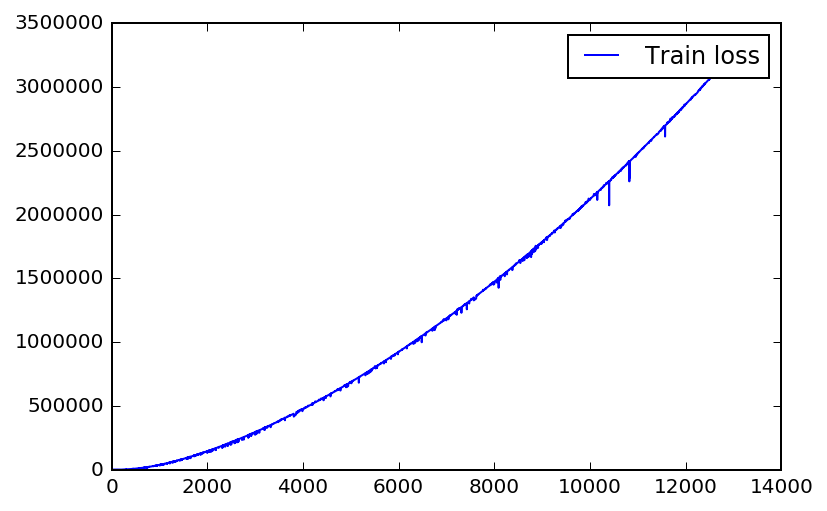

In [38]:
# Display the learning curve and losses for training, validation, and testing
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

plt.plot(net.losses['train'], label='Train loss')
# matplot.plot(losses_tx2['valid'], label='Valid loss')
plt.legend()
# _ = plt.ylim()